In [45]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation
import sodshock
# FDM solution to 1D Euler Equations
# Initial Conditions - 1D sod shock tube initial conditions
# Dirichlet Boundary Conditions
# Constants

gamma = 1.4

# initial conditions: (p, rho, u)_{t = 0} = (1, 1, 0) if x in (0, 0.5] and (0.1, 0.125, 0) if x in (0.5, 1.0)
def sod_initial_conditions(nx=500, x0=0.5, x_min=0.0, x_max=1.0, left_state=(1, 1, 0), right_state=(0.1, 0.125, 0)):
    p_l, rho_l, u_l = left_state
    p_r, rho_r, u_r = right_state
    x = np.linspace(x_min, x_max, nx)
    rho = np.where(x < x0, rho_l, rho_r)
    u = np.where(x < x0, u_l, u_r)
    p = np.where(x < x0, p_l, p_r)
    return x, rho, u, p

# pressure related to conserved quantities through the equation of state given by p = (gamma - 1)(E - 1/2 pu^2)
# gamma = 1.4
# this method and next method are convert between energy and pressure
def primitive_to_conservative(rho, u, p):
    E = p / (gamma - 1) + 0.5 * rho * u**2
    return np.array([rho, rho * u, E])

def conservative_to_primitive(U):
    rho = U[0]
    u = U[1] / rho
    E = U[2]
    p = (gamma - 1) * (E - 0.5 * rho * u**2)
    return rho, u, p


def compute_flux(U):
    rho, u, p = conservative_to_primitive(U)
    E = U[2]
    return np.array([
        rho * u,
        rho * u**2 + p,
        u * (E + p)
    ])

def rusanov_flux(U_L, U_R):
    flux_L = compute_flux(U_L)
    flux_R = compute_flux(U_R)

    rho_L, u_L, p_L = conservative_to_primitive(U_L)
    rho_R, u_R, p_R = conservative_to_primitive(U_R)

    c_L = np.sqrt(gamma * p_L / rho_L)
    c_R = np.sqrt(gamma * p_R / rho_R)

    s_max = max(abs(u_L) + c_L, abs(u_R) + c_R)

    return 0.5 * (flux_L + flux_R) - 0.5 * s_max * (U_R - U_L)

def apply_boundary_conditions(U, bc_L, bc_R):
    # Simple transmissive (zero gradient) boundaries
    U[:, 0] = U[:, 1]
    U[:, -1] = U[:, -2]

    return U

def plot_solution(x, rho, u, p, left_state, right_state):
    gamma = 1.4
    npts = 500
    t = 0.1
    #left_state = (1,1,0)
    #right_state = (0.1, 0.125, 0.)

    # left_state and right_state set pressure, density and u (velocity)
    # geometry sets left boundary on 0., right boundary on 1 and initial
    # position of the shock xi on 0.5
    # t is the time evolution for which positions and states in tube should be 
    # calculated
    # gamma denotes specific heat
    # note that gamma and npts are default parameters (1.4 and 500) in solve 
    # function
    positions, regions, values = sodshock.solve(left_state=left_state, right_state=right_state, 
                                                geometry=(0., 1., 0.5), t=t, gamma=gamma, npts=npts, dustFrac=0)
    x = values['x']
    p_final = values['p']
    rho_final = values['rho']
    u_final = values['u']
    
    # need to spatialize left_state, right_state
    barrier_loc = int(npts/2-1)
    p_init = np.zeros_like(p_final)
    rho_init = np.zeros_like(rho_final)
    u_init = np.zeros_like(u_final)
        
    # left_state
    for i in range(barrier_loc+1):
        p_init[i] = left_state[0]
        rho_init[i] = left_state[1]
        u_init[i] = left_state[2]
        
    # right state
    for i in range(barrier_loc+1, len(x)):
        p_init[i] = right_state[0]
        rho_init[i] = right_state[1]
        u_init[i] = right_state[2]
    fig, ax = plt.subplots(2, 3, figsize=(24, 8), dpi=100, sharey=False, sharex=True)
    
    ax[0,0].plot(x, p_init, label="Initial Condition", linewidth=3, color='b')
    ax[0,0].plot(x, p_final, label="Ground Truth", linewidth=3, color='k')
    ax[0,0].plot(x, p, label="Rusanov Prediction", color='g', linewidth=3)
    ax[0,0].set_title("Pressure Profile for Canonical Example")
    ax[0,0].legend()

    ax[0,1].plot(x, rho_init, label="Initial Condition", linewidth=3, color='b')
    ax[0,1].plot(x, rho_final, label="Ground Truth", linewidth=3, color='k')
    ax[0,1].plot(x, rho, label="Rusanov Prediction", color='g', linewidth=3)
    ax[0,1].set_title("Density Profile for Canonical Example")
    ax[0,1].legend()
    
    ax[0,2].plot(x, u_init, label="Initial Condition", linewidth=3, color='b')
    ax[0,2].plot(x, u_final, label="Ground Truth", linewidth=3, color='k')
    ax[0,2].plot(x, u, label="Rusanov Prediction", color='g', linewidth=3)
    ax[0,2].set_title("Velocity Profile for Canonical Example")
    ax[0,2].legend()
    
    ax[1, 0].plot(x, np.abs(p_final - p), label="Absolute Error", c="k", lw=3)
    ax[1, 0].set_yscale('log')
    ax[1, 0].set_title(f"Absolute Error in Pressure Profile (L\u00b2 Error: {np.linalg.norm(p_final - p):.4f})")
        
    ax[1, 1].plot(x, np.abs(rho_final-rho), label="Absolute Error", c="k", lw=3)
    ax[1, 1].set_yscale('log')
    ax[1, 1].set_title(f"Absolute Error in Density Profile (L\u00b2 Error: {np.linalg.norm(rho_final-rho):.4f})")

    ax[1, 2].plot(x, np.abs(u_final - u), label="Absolute Error", c="k", lw=3)
    ax[1, 2].set_yscale('log')
    ax[1, 2].set_title(f"Absolute Error in Velocity Profile (L\u00b2 Error: {np.linalg.norm(u_final - u):.4f})")

In [46]:
def sod_solver(nx=500, CFL=0.75, t_end=0.1, left_state=(1, 1, 0), right_state=(0.1, 0.125, 0)):
    x, rho, u, p = sod_initial_conditions(nx=nx, left_state=left_state, right_state=right_state)
    dx = x[1] - x[0]

    U = primitive_to_conservative(rho, u, p)
    t = 0.0

    # fixed dt instead of the adaptive one to make animation easier
    #dt = 0.001

    history = np.array([conservative_to_primitive(U)])

    while t < t_end:
        # disabled diffusive BCs
        #U = apply_boundary_conditions(U)
        rho, u, p = conservative_to_primitive(U)
        c = np.sqrt(gamma * p / rho)
        dt = CFL * dx / np.max(np.abs(u) + c)
        if t + dt > t_end:
            dt = t_end - t

        # Compute fluxes at interfaces
        F = np.zeros_like(U)
        for i in range(1, nx-1):
            F[:, i] = rusanov_flux(U[:, i], U[:, i + 1])
            #F[:, i] = hllc_flux(U[:, i], U[:, i + 1])

        # Update U
        dU = dt / dx * (F[:, 1:-1] - F[:, 0:-2])

        # setting the update on either end to zero to enforce a dirichlet condition
        # in a slightly hacky way that isn't valid at steady state. 
        # better would be to pad U with fixed ghost cells when calculating fluxes
        dU[:,0] = 0
        dU[:,-1] = 0

        U[:, 1:-1] -= dU

        t += dt

        history = np.concatenate((history, np.array([conservative_to_primitive(U)])), axis=0)
                                 
    # print(dt)
    rho, u, p = conservative_to_primitive(U)
    return x, rho, u, p, history, dt
nx = 500
CFL=0.75
t_end=0.1



[((1, 1, 0), (0.1, 0.125, 0)), ((2, 1, 0), (0.1, 0.125, 0)), ((3, 1, 0), (0.1, 0.125, 0)), ((4, 1, 0), (0.1, 0.125, 0)), ((5, 1, 0), (0.1, 0.125, 0))]


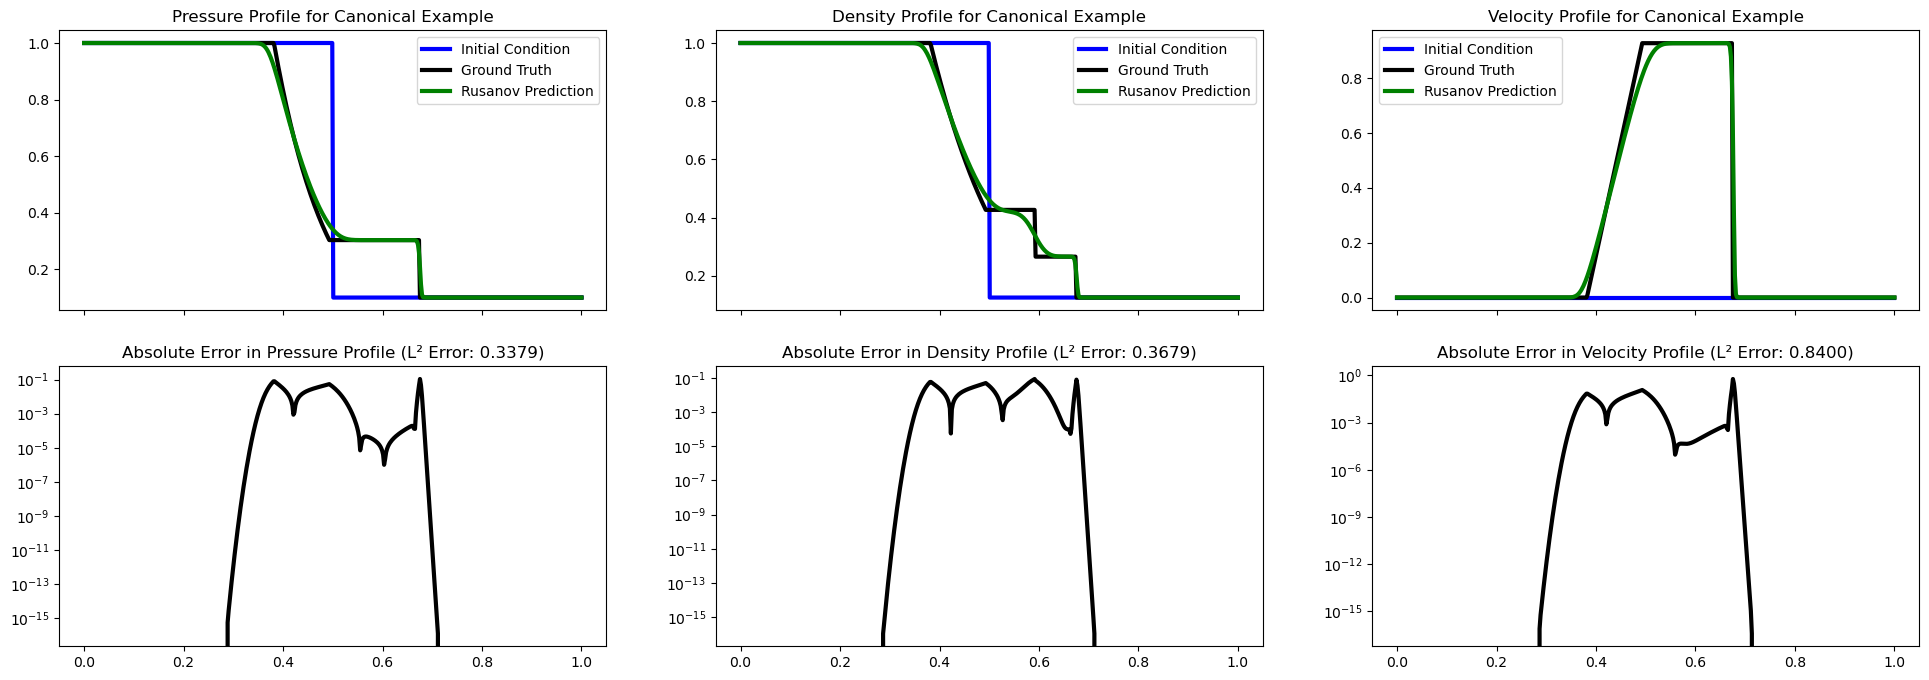

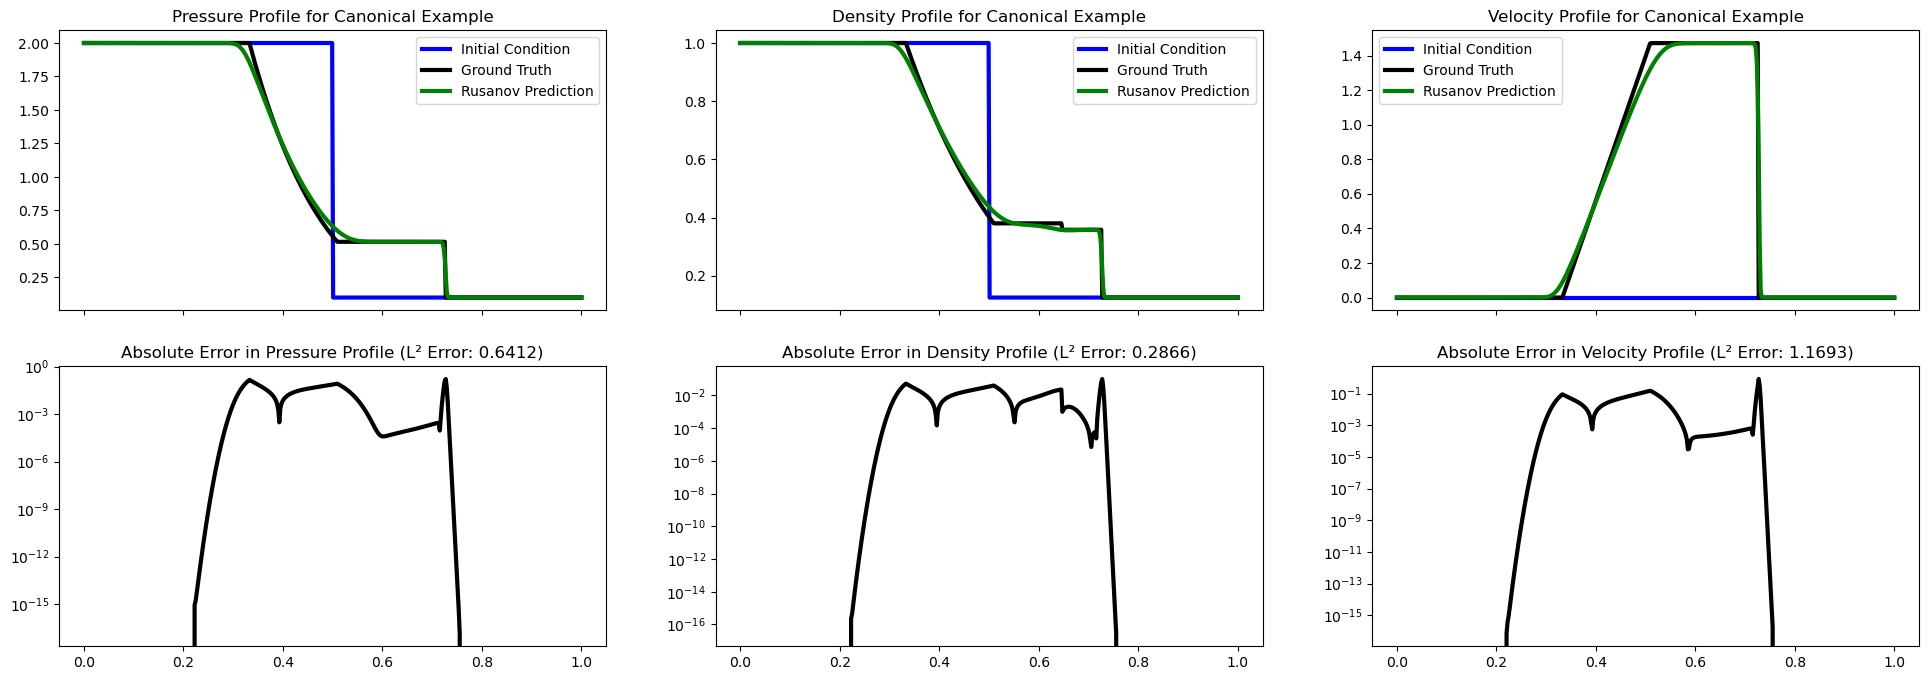

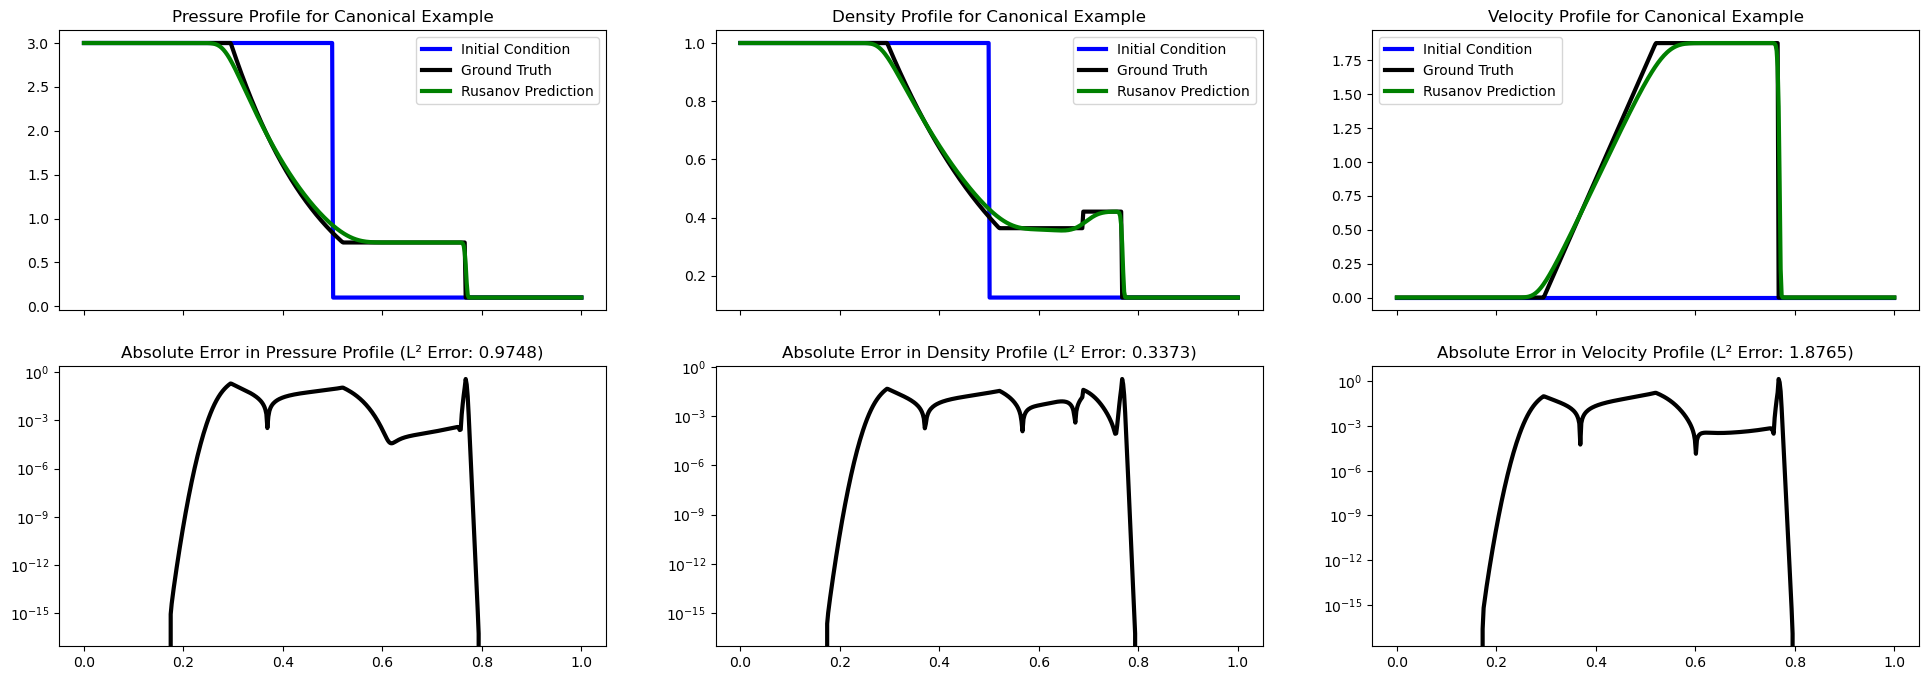

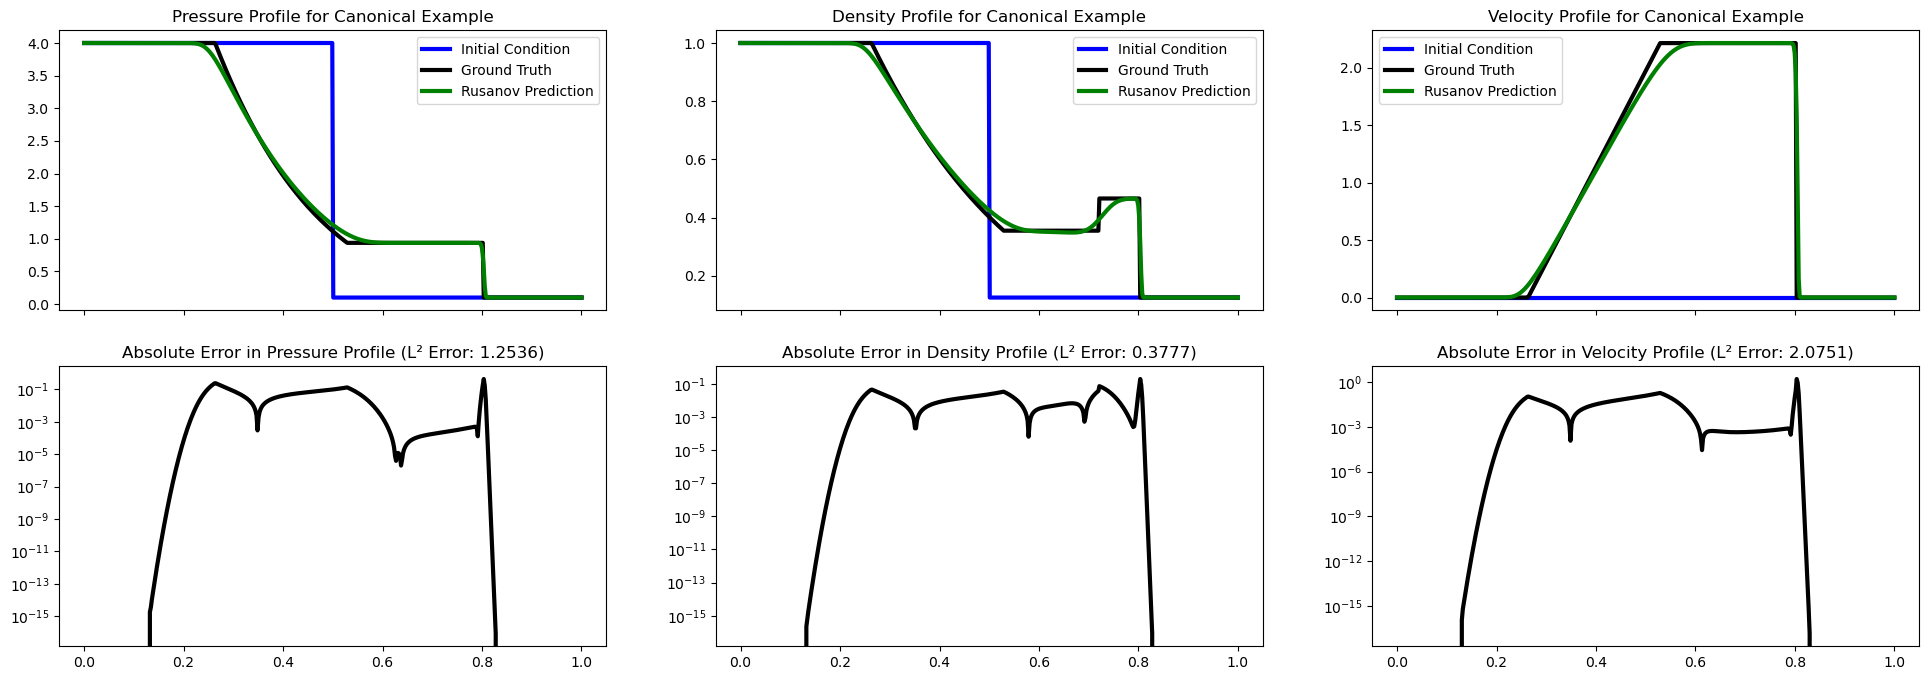

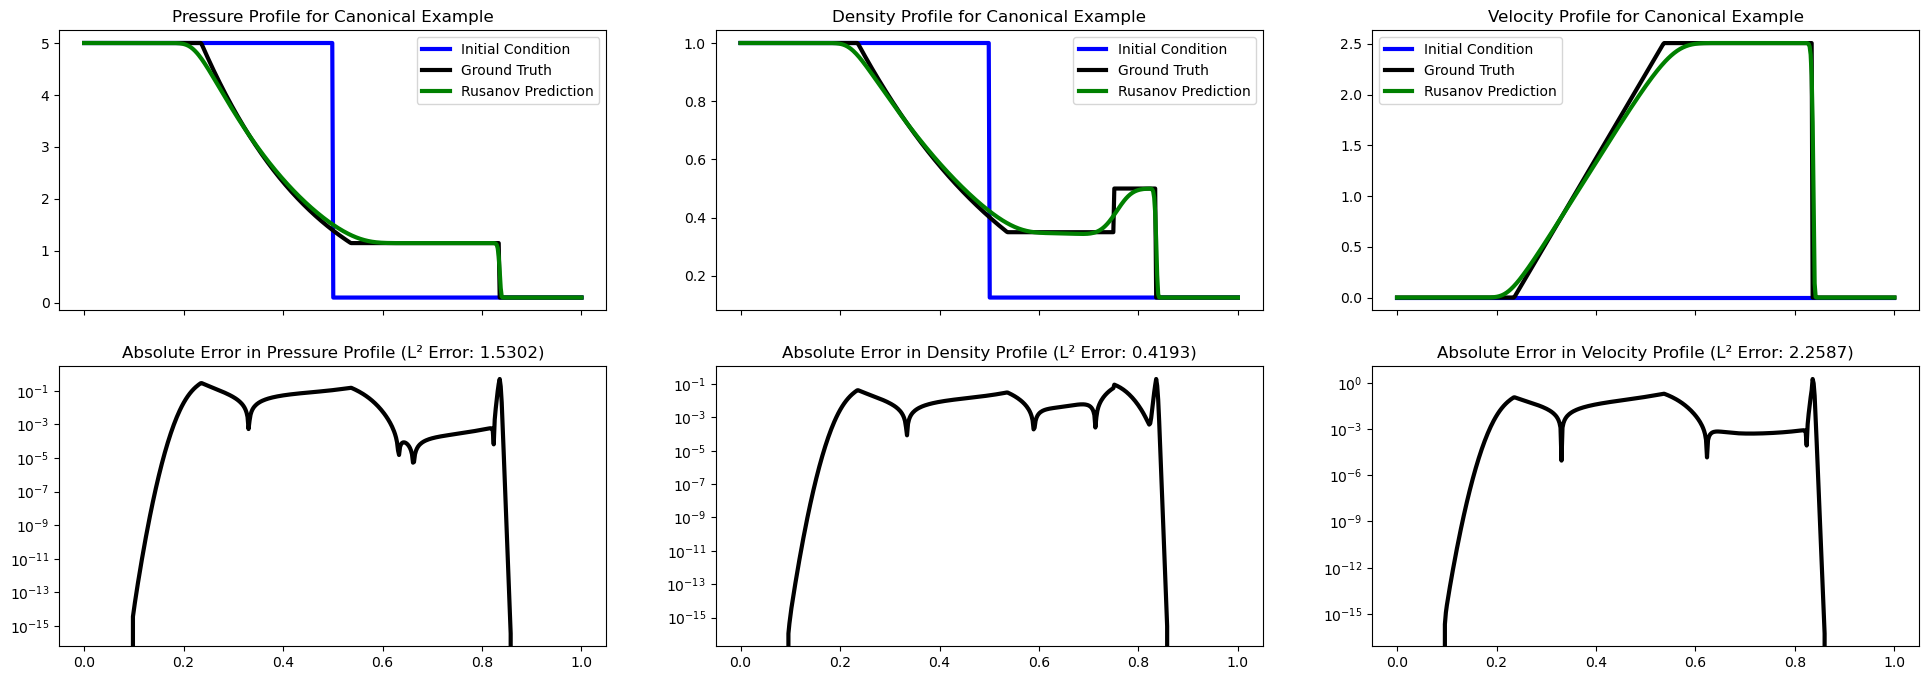

In [47]:
# Run and Plot 
left_states=[(p, 1, 0) for p in [1, 2, 3, 4, 5]]
right_state=(0.1, 0.125, 0)
states = [(left_state, right_state) for left_state in left_states]
print(states)
for left_state, right_state in states:
    x, rho, u, p, history, dt = sod_solver(nx = nx, CFL = CFL, t_end = t_end, left_state=left_state, right_state=right_state)
    plot_solution(x, rho, u, p, left_state, right_state)


In [7]:
#rho, u, p = history[50,:]
#plot_solution(x, rho, u, p)

In [6]:
# started work on animating the results using this stackoverflow
# https://stackoverflow.com/questions/43445103/inline-animations-in-jupyter

def animate_solution(U_history, dt):
        
        
        fig,((ax1), (ax2), (ax3)) = plt.subplots(3,1)
        fig.set_size_inches(12,8)

        ax1.axis([0,1,0,1])
        den, = ax1.plot([], [])
        plt.ylabel('Density')

        ax2.axis([0,1,-1,1])
        vel = ax2.plot([], [])
        plt.ylabel('Velocity')
        

        ax3.axis([0,1,0,1])
        pre = ax3.plot([], [])
        plt.ylabel('Pressure')
        plt.xlabel('x')

        plt.tight_layout()
        #plt.show()

        def animate(i):
            den.set_data()

    #for i in np.shape(U_history)[0]:
        